# Sample Code for Likelihood Ratios for Categorical Count Data

## LR under the proposed model

Recall that the formula for the likelihood ratio under the proposed model is
<p align="center">
<img src="lr_formula.png" width="300">
</p>
where B(.) denotes the multivariate beta function.
The multivariate beta function is defined as
<p align="center">
<img src="mv_beta.png" width="250">
</p>

## Functions for computing the LR

* `calc_lnlr` calculates the natural log transformed likelihood ratio for a given set of prior parameters and pair of counts. This just implements the formula above (on the natural log scale for stability).
* `get_lnlr_from_seq` calculates natural log transformed likelihood ratios for a given set of prior parameters and sequence of events. This could be provided via two sequences to compare or a single sequence with a dividing event index. Can also be provided with a window of event indices around which to do the calculations, instead of for a fixed dividing time.

In [2]:
from scipy import special
import numpy as np
import pandas as pd

In [3]:
# Calculate the ln(LR) for a given pair of counts and prior
#
# alpha: 1-dimensional array of length K containing the Dirichlet prior parameters
# r1: 1-dimensional array of length K containing the event counts for the known source
# r2: 1-dimensional array of length K containing the event counts for the unknown source
#
def calc_lnlr(r1, r2, alpha = None):
    
    if(r1.shape[0] != r2.shape[0]):
        raise Exception("Different K's implied by r1 and r2.")
        
    if(np.sum(alpha == None) == 0):
        if(alpha.shape[0] != r1.shape[0]):
            raise Exception("Different K's implied by alpha and r1.")
    else:
        alpha = np.ones(r1.shape[0])
    
    # calculate ln(LR) using counts and prior parameters
    lnlr = (np.sum(special.loggamma(alpha + r1 + r2)) - special.loggamma(np.sum(alpha + r1 + r2))
           - np.sum(special.loggamma(alpha + r1)) + special.loggamma(np.sum(alpha + r1))
           - np.sum(special.loggamma(alpha + r2)) + special.loggamma(np.sum(alpha + r2))
           + np.sum(special.loggamma(alpha)) - special.loggamma(np.sum(alpha))) 
    
    return lnlr

In [6]:
# Calculate the ln(LR) for a given sequence of events
#
# event_seq: 1-dimensional array containing a sequence of events
#   - if event_seq2 is also specified, then event_seq consists of only the known
#     source events (N_1 events) and then event_seq2 will have the unknown 
#     source events (N_2 events)
#   - if event_seq2 is not also specified, then this event sequence has all N
#     events and will be split up into N_1 + N_2 events
# event_seq2: optional 1-dimensional array containing the unknown source events
#   - will be used to compare against event_seq
# event_ind: a 1-dimensional array of integers specifying the  
#             event indices (i.e., N_1's) at which to calculate the LR
#   - if not specified with a single sequence, defaults to floor of N / 2
#   - if not specified with two sequences, defaults to just comparing the two
#     sequences
#   - if specified as a single integer, function will return a single LR value
#   - if specified as a vector, function will return a vector of LR values
# categories: list of length K specifying the LR categories
#   - if not specified, defaults to the event types in event_seq
#   - note that if specified, events in event_seq not in these categories will 
#     be ignored
# alpha: 1-dimensional array of length K containing the Dirichlet prior parameters
#   - if not specified, defaults to uniform Dirichlet
#

def get_lnlr_from_seq(event_seq, event_seq2 = None, event_ind = None, categories = None, alpha = None):
    
    # concatenate second event sequence if specified
    if(np.sum(event_seq2 == None) == 0):
        event_seq = np.concatenate([event_seq, event_seq2])
        
    # ignore empty events
    event_seq = event_seq[event_seq != None]
        
    if(np.sum(categories == None) == 0):
        # ignore events outside specified categories
        event_seq = event_seq[np.isin(event_seq, categories)]
    else:
        # get categories from the unique events in the sequence if not specified
        categories = np.unique(event_seq).tolist()
        
    # treat event sequence as categorical
    event_seq = pd.Series(pd.Categorical(event_seq, categories = categories, ordered = True))
    
    # get number of categories
    K = len(categories)
    # get number of events    
    N = event_seq.shape[0]
        
    # error check inputs
    if(np.sum(alpha == None) == 0):
        if(alpha.shape[0] != K):
            raise Exception("The number of prior parameters is not equal to the number of categories.")
            
        if(np.sum(alpha <= 0) > 0):
            raise Exception("All prior parameters need to be greater than 0.")
    else:
        alpha = np.ones(K)
        
    if(np.sum(event_ind == None) == 0):
        
        if(np.sum(event_ind < 1) > 0):
            raise Exception("There are event indices less than 1.")
        
        if(np.sum(event_ind > N - 1) > 0):
            raise Exception("There are event indices greater than the length of the event sequence.")
    else:
        if(np.sum(event_seq2 == None) == 0):
            event_ind = N - event_seq2.shape[0]
        else:
            event_ind = np.floor(N / 2)
            
    # list to store ln(LR) vals
    lnlr = []
    
    if(isinstance(event_ind, int)):
        
        # calculate single LR value if only index provided
        r1 = np.array(event_seq[0:event_ind].value_counts().sort_index())
        r2 = np.array(event_seq[event_ind:N].value_counts().sort_index())
        lnlr.append(calc_lnlr(r1, r2, alpha))
    else:
        
        # loop through all indices if multiple provided
        for i in event_ind:
            r1 = np.array(event_seq[0:i].value_counts().sort_index())
            r2 = np.array(event_seq[i:N].value_counts().sort_index())
            lnlr.append(calc_lnlr(r1, r2, alpha))

    return lnlr
            
        

## Toy examples

In [7]:
np.random.seed(1234)

Let's consider three event types of interest, "A", "B", and "C".

In [8]:
toy_categories = ["A", "B", "C"]

Suppose we have identical event counts, r<sub>1</sub> = r<sub>2</sub> = (2, 1, 0).
We can use the `calc_lnlr` function in order to calculate the likelihood ratio using these counts directly.

In [9]:
np.exp(calc_lnlr(alpha = np.ones(3), r1 = np.array([2, 1, 0]), r2 = np.array([2, 1, 0])))

2.14285714285714

We could also represent these counts as two sequences and then calculate the likelihood ratio.

In [10]:
np.exp(get_lnlr_from_seq(event_seq = np.array(["A", "A", "B"]), event_seq2 = np.array(["A", "A", "B"]), categories = toy_categories))

array([2.14285714])

Or alternatively as a single sequence with a specified dividing index.

In [13]:
np.exp(get_lnlr_from_seq(event_seq = np.array(["A", "A", "B", "A", "A", "B"]), categories = toy_categories, event_ind = 3))

array([2.14285714])

We could also evaluate the likelihood ratio throughout a window of events in the sequence, instead of only at a fixed event index.
The function below calculates the likelihood ratio three times on the sequence: "A", "A", "B", "A", "A", "B".

* A, A VS. B, A, A, B
* A, A, B VS. A, A, B
* A, A, B, A, VS. A, B

In [14]:
np.exp(get_lnlr_from_seq(event_seq = np.array(["A", "A", "B", "A", "A", "B"]), categories = toy_categories, event_ind = np.array([2, 3, 4])))

array([1.28571429, 2.14285714, 1.71428571])

We can also do this for a longer sequence and then plot the resulting likelihood ratios across the event indices.
We construct a sequence of 1000 events; the first 500 will be mostly "A" events and then there's a change and the second 500 events will be mostly "C" events.
Ideally, the likelihood ratio demonstrates that there is a change around the 500th event.

In [15]:
long_seq = np.concatenate([np.random.choice(toy_categories, 500, p=[0.9, 0.05, 0.05]),
                         np.random.choice(toy_categories, 500, p=[0.05, 0.05, 0.9])])

lnlr = get_lnlr_from_seq(event_seq = long_seq, categories = toy_categories, event_ind = np.arange(1, 1000))

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [10, 5]

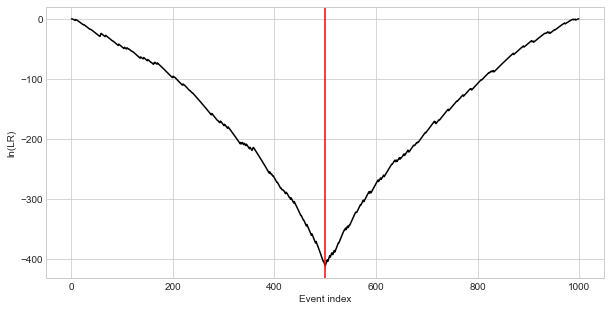

In [17]:
plt.plot(np.arange(1, 1000), lnlr, color='black')
plt.axvline(x = 500, color = 'red')
plt.xlabel("Event index")
plt.ylabel("ln(LR)");